In [154]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc("figure", figsize=(25,15))

In [257]:
pd.options.mode.chained_assignment = None  # default='warn'

In [258]:
negocios = pd.read_excel('Negócios enriquecidos.xlsx')
validacao = pd.read_excel('Negócios enriquecidos - Validação.xlsx')

In [259]:
print(negocios.shape)

(376, 12)


In [260]:
print(negocios.dtypes)

Unnamed: 0            int64
Unnamed: 0.1        float64
Cidade               object
Negócio              object
Contagem              int64
Estado               object
População             int64
IDH                 float64
pibPerCapita        float64
Frota_Total           int64
Frota_Automóveis      int64
Frota_Motos           int64
dtype: object


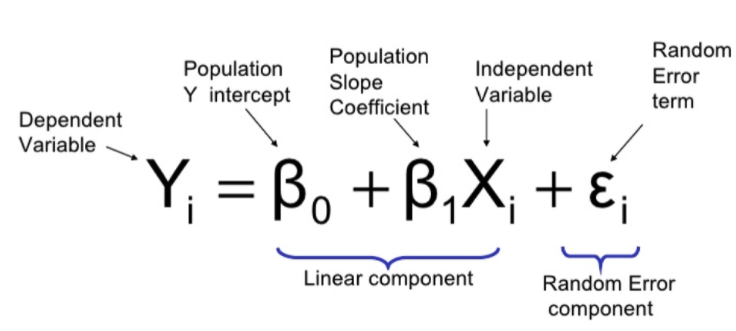

Fonte: https://www.mwbrady.com/post/olsregression/

In [261]:
negocios['Negócio'].unique()

array(['Posto de gasolina', 'Depósito de construção', 'Pet Shop'],
      dtype=object)

#### Reduzindo efeito de extrações duplicadas ou indevidas
- descontar 20% para número de negócios acima de 70
- descontar 15% para número de negócios entre 30 e 70 
- descontar 10% para o número de negócios até 15 e 30


In [262]:
#Minimizando o efeito de extrações incoerentes
for i in range(len(negocios)):
    quantidade = negocios['Contagem'][i]
    if quantidade >=70:
        negocios.loc[i,'Contagem'] = quantidade*0.8
    elif (quantidade >= 30) and (quantidade < 70):
        negocios.loc[i,'Contagem'] = quantidade*0.85
    elif (quantidade >= 15) and (quantidade < 30):
        negocios.loc[i,'Contagem'] = quantidade*0.9
        
#Minimizando o efeito de extrações incoerentes
for i in range(len(validacao)):
    quantidade = validacao['Contagem'][i]
    if quantidade >=70:
        validacao.loc[i,'Contagem'] = quantidade*0.8
    elif (quantidade >= 30) and (quantidade < 70):
        validacao.loc[i,'Contagem'] = quantidade*0.85
    elif (quantidade >= 15) and (quantidade < 30):
        validacao.loc[i,'Contagem'] = quantidade*0.9

In [263]:
negocios['Contagem'].sample(5)

252     22.50
366    108.80
365     45.05
166     39.95
126     18.00
Name: Contagem, dtype: float64

Criando as variáveis: frota total/hab, automóveis/habitante, moto/habitante, carro/moto

In [264]:
negocios['Total_por_habitantes'] = negocios['Frota_Total']/negocios['População']
negocios['Automoveis_por_habitante'] = negocios['Frota_Automóveis']/negocios['População']
negocios['Motos_por_habitante']=negocios['Frota_Motos']/negocios['População']
negocios['Carro_por_moto']= negocios['Frota_Automóveis']/negocios['Frota_Motos']

#Criando essas colunas nos dados de validação
validacao['Total_por_habitantes'] = validacao['Frota_Total']/validacao['População']
validacao['Automoveis_por_habitante'] = validacao['Frota_Automóveis']/validacao['População']
validacao['Motos_por_habitante']=validacao['Frota_Motos']/validacao['População']
validacao['Carro_por_moto']= validacao['Frota_Automóveis']/validacao['Frota_Motos']

In [265]:
negocios['Automoveis_por_habitante']

0      0.192448
1      0.333531
2      0.304757
3      0.284894
4      0.343549
         ...   
371    0.237525
372    0.123173
373    0.147901
374    0.124600
375    0.102553
Name: Automoveis_por_habitante, Length: 376, dtype: float64

In [266]:
negocios['Motos_por_habitante']

0      0.226250
1      0.178973
2      0.233917
3      0.204032
4      0.128477
         ...   
371    0.193934
372    0.153080
373    0.172070
374    0.166823
375    0.295717
Name: Motos_por_habitante, Length: 376, dtype: float64

### Criando um dataframe para cada tipo de negócio

In [267]:
postos = negocios[negocios['Negócio']=='Posto de gasolina']
deposito = negocios[negocios['Negócio']=='Depósito de construção']
petshop = negocios[negocios['Negócio']=='Pet Shop']

#Estabelecendo a coluna "Cidade" como indice dos dados
postos.set_index('Cidade', inplace=True)
deposito.set_index('Cidade', inplace=True)
petshop.set_index('Cidade', inplace=True)

(1) Estimando quantidade de **postos de gasolina**

Primeira iteração da regressão múltipla

In [268]:
import statsmodels.formula.api as smf

In [269]:
reg = smf.ols('Contagem ~ Frota_Automóveis + Frota_Motos + pibPerCapita + Carro_por_moto' , data = postos)
#Métodos e propriedades do objeto "Regressão por OLS"
#print(dir(reg))

In [270]:
res = reg.fit()
#Métodos e objetos do objeto "Fit da regressão por OLS"
#Listar tods métodos e propriedades de um objeto te permite ter uma noção maior das potencialidades da ferramenta.
#print(dir(res))

In [271]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Contagem   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     189.8
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           1.27e-51
Time:                        13:49:18   Log-Likelihood:                -503.97
No. Observations:                 128   AIC:                             1018.
Df Residuals:                     123   BIC:                             1032.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.7321      4.026  

Avaliando se os resíduos do modelo aprentam distribuição normal

Figure(1800x1080)


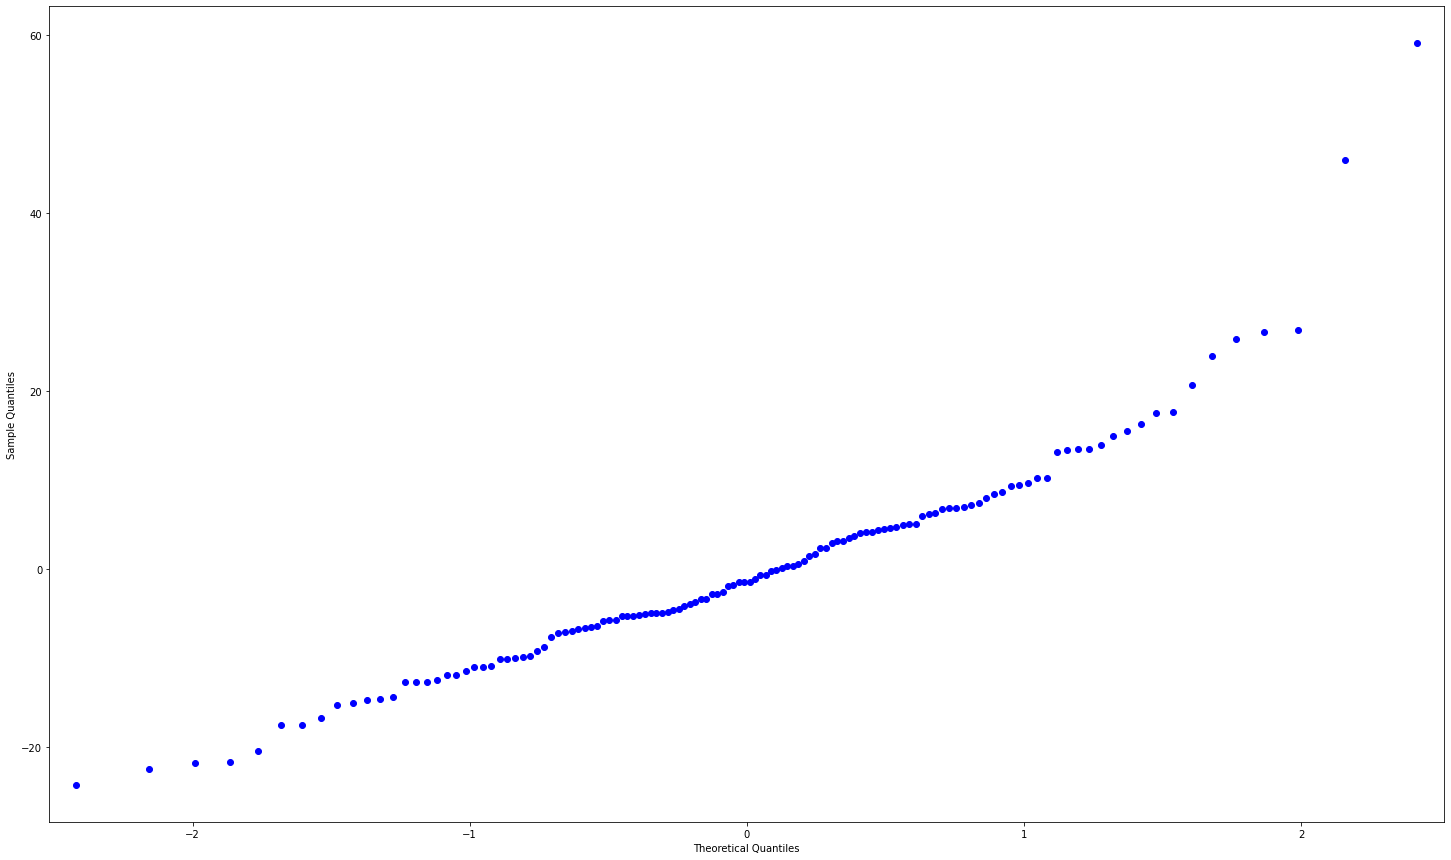

In [272]:
import statsmodels.api as sm
print(sm.qqplot(res.resid))

In [273]:
infl = res.get_influence()
print(infl.hat_matrix_diag)

[0.09471947 0.09305681 0.0226163  0.01273212 0.01285419 0.01691167
 0.01320206 0.09305681 0.01339489 0.03580938 0.08006513 0.01436035
 0.02217515 0.01422459 0.03890036 0.01027684 0.01013983 0.04037965
 0.02477744 0.02291477 0.02881083 0.03050119 0.06913547 0.06443121
 0.00989359 0.01911361 0.00949464 0.01535105 0.05571255 0.08180586
 0.0266035  0.0359321  0.03847604 0.01429306 0.0266035  0.0359321
 0.01429306 0.05624266 0.13896983 0.02052053 0.00879696 0.04659943
 0.03055636 0.12681292 0.0095705  0.3152038  0.05583307 0.01677997
 0.01037032 0.01583949 0.13287812 0.0269417  0.01126919 0.0882083
 0.02033744 0.00988542 0.14445288 0.03156485 0.02582051 0.01309817
 0.0451938  0.08152362 0.03297955 0.06990645 0.03229676 0.02139253
 0.0131256  0.00976672 0.01840549 0.01331615 0.01606458 0.01363091
 0.02917005 0.02678388 0.03281288 0.01721952 0.01339594 0.02517494
 0.03850153 0.01294951 0.0145101  0.01981117 0.01413855 0.04113091
 0.04591536 0.02290291 0.02245243 0.03017013 0.03399609 0.027910

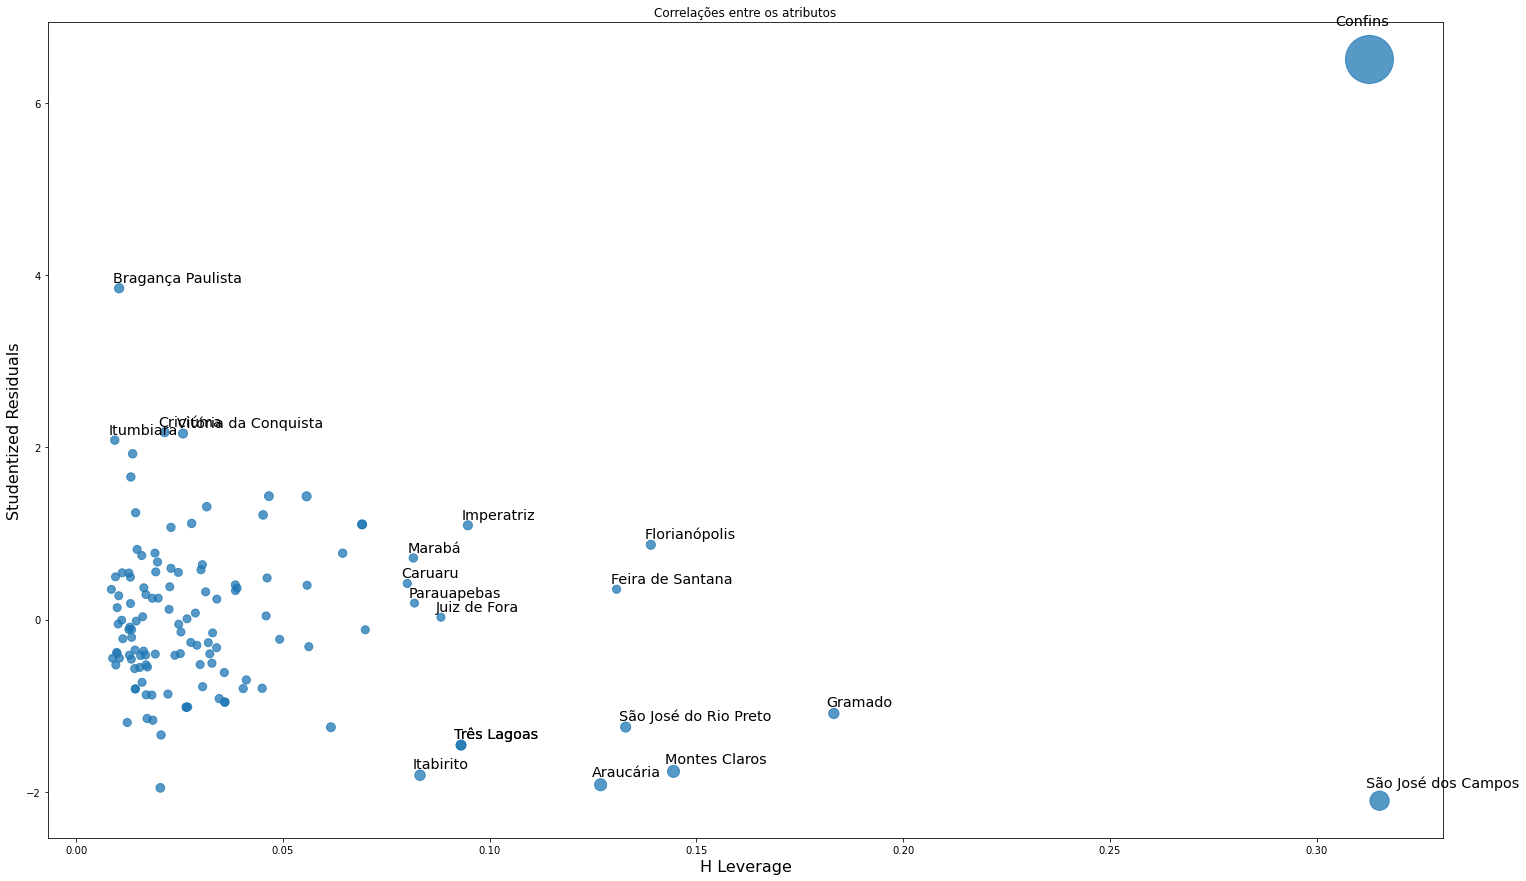

In [274]:
sm.graphics.influence_plot(res)
plt.title("Correlações entre os atributos")
plt.rc("figure", figsize=(25,15))
plt.show()

In [275]:
#A coleta para a cidade de Confins, claramente não funcionou
#Bragança Paulista apresenta um número de postos muito acima do esperado.
postos.loc[['Confins','Bragança Paulista']]

,Unnamed: 0,Unnamed: 0.1,Negócio,Contagem,Estado,População,IDH,pibPerCapita,Frota_Total,Frota_Automóveis,Frota_Motos,Total_por_habitantes,Automoveis_por_habitante,Motos_por_habitante,Carro_por_moto
Cidade,,,,,,,,,,,,,,,
Confins,91,0.0,Posto de gasolina,100.8,MG,6800,0.747,163730.37,5457,2882,791,0.802500,0.423824,0.116324,3.643489
Bragança Paulista,48,0.0,Posto de gasolina,109.6,SP,170533,0.776,37813.45,134740,76388,29258,0.790111,0.447937,0.171568,2.610841


In [276]:
print(len(postos))
#Removendo o dado de Confins e Bragança Paulista
postos.drop(index = ['Confins','Bragança Paulista'], inplace=True)
print(len(postos))

128
126


                            OLS Regression Results                            
Dep. Variable:               Contagem   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     296.9
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           1.54e-61
Time:                        13:49:20   Log-Likelihood:                -468.06
No. Observations:                 126   AIC:                             946.1
Df Residuals:                     121   BIC:                             960.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.6053      3.280  

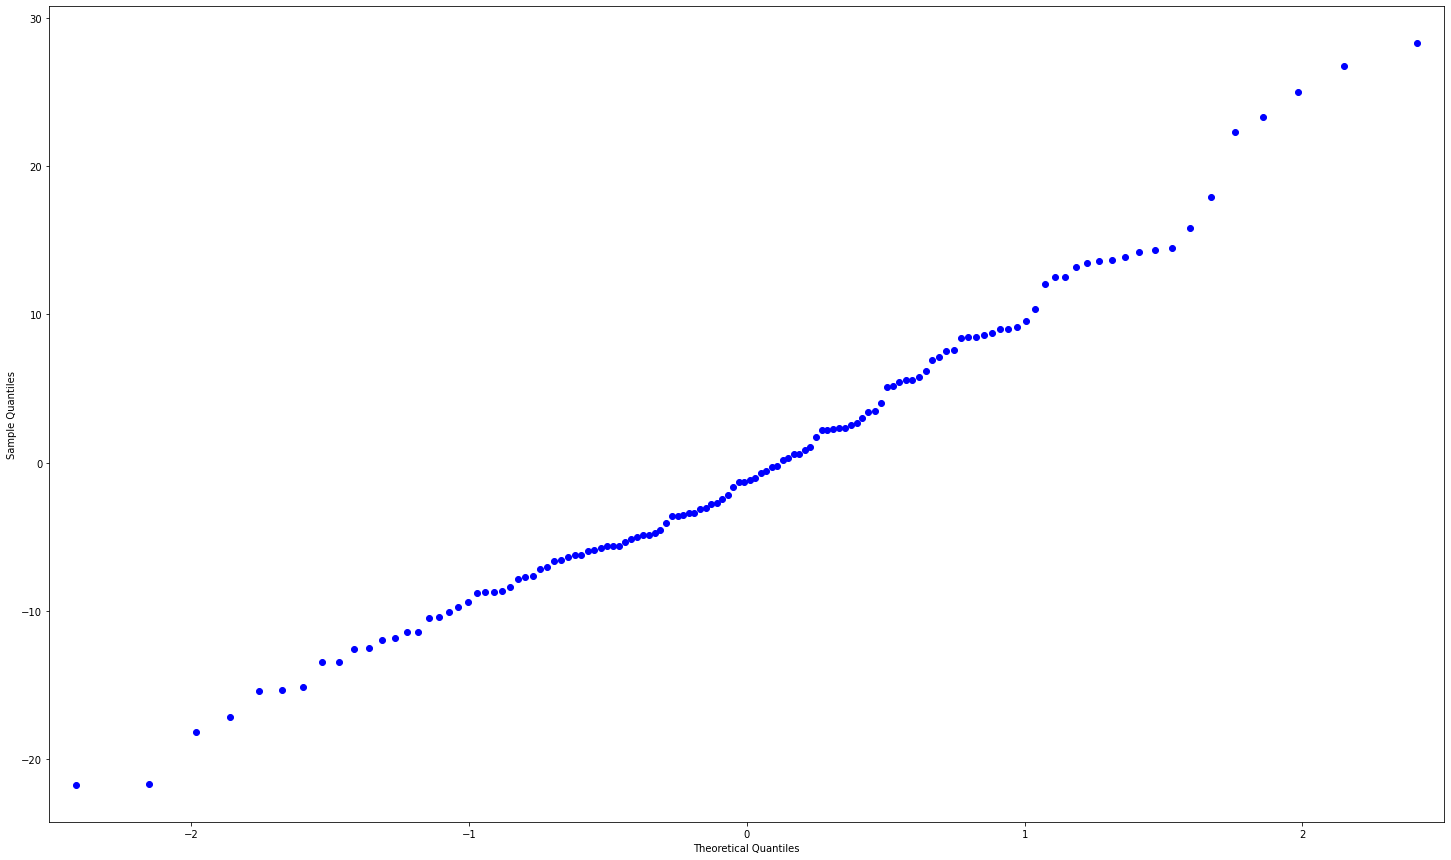

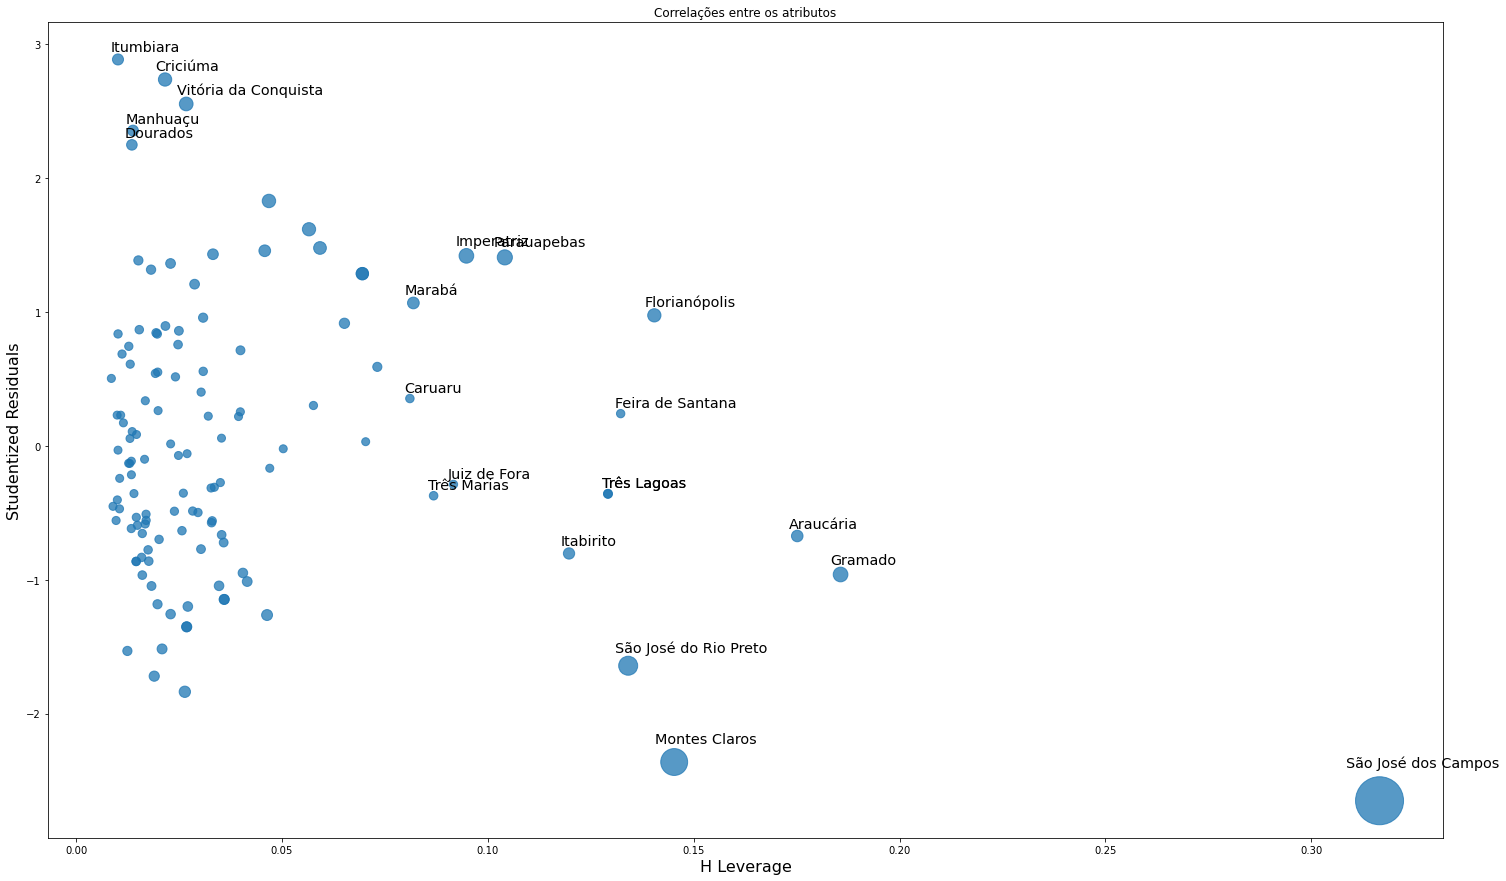

In [277]:
#Plotando novamente os resultados
reg = smf.ols('Contagem ~ Frota_Automóveis + Frota_Motos + pibPerCapita + Carro_por_moto' , data = postos)
res = reg.fit()
print(res.summary())
print(sm.qqplot(res.resid))
sm.graphics.influence_plot(res)
plt.title("Correlações entre os atributos")
plt.rc("figure", figsize=(25,15))
plt.show()

**Última iteração da regressão e armazenamento dos seus parâmetros**

In [278]:
#Removendo a variável pibPerCapita
regPostos = smf.ols('Contagem ~ Frota_Automóveis + Frota_Motos + Carro_por_moto' , data = postos)
resPostos = regPostos.fit()
print(resPostos.summary())

                            OLS Regression Results                            
Dep. Variable:               Contagem   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     399.0
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           7.23e-63
Time:                        13:49:20   Log-Likelihood:                -468.08
No. Observations:                 126   AIC:                             944.2
Df Residuals:                     122   BIC:                             955.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7857      3.139  

(2) Estimando quantidade de **depósitos de construção**

Primeira iteração da regressão múltipla

In [279]:
reg = smf.ols('Contagem ~ População + pibPerCapita + IDH' , data = deposito)
#Métodos e propriedades do objeto "Regressão por OLS"
#print(dir(reg))

In [280]:
res = reg.fit()
#Métodos e objetos do objeto "Fit da regressão por OLS"
#Listar tods métodos e propriedades de um objeto te permite ter uma noção maior das potencialidades da ferramenta.
#print(dir(res))

In [281]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Contagem   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     71.99
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           7.23e-27
Time:                        13:49:21   Log-Likelihood:                -530.87
No. Observations:                 126   AIC:                             1070.
Df Residuals:                     122   BIC:                             1081.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -64.3770     24.883     -2.587   

Figure(1800x1080)
Figure(1800x1080)


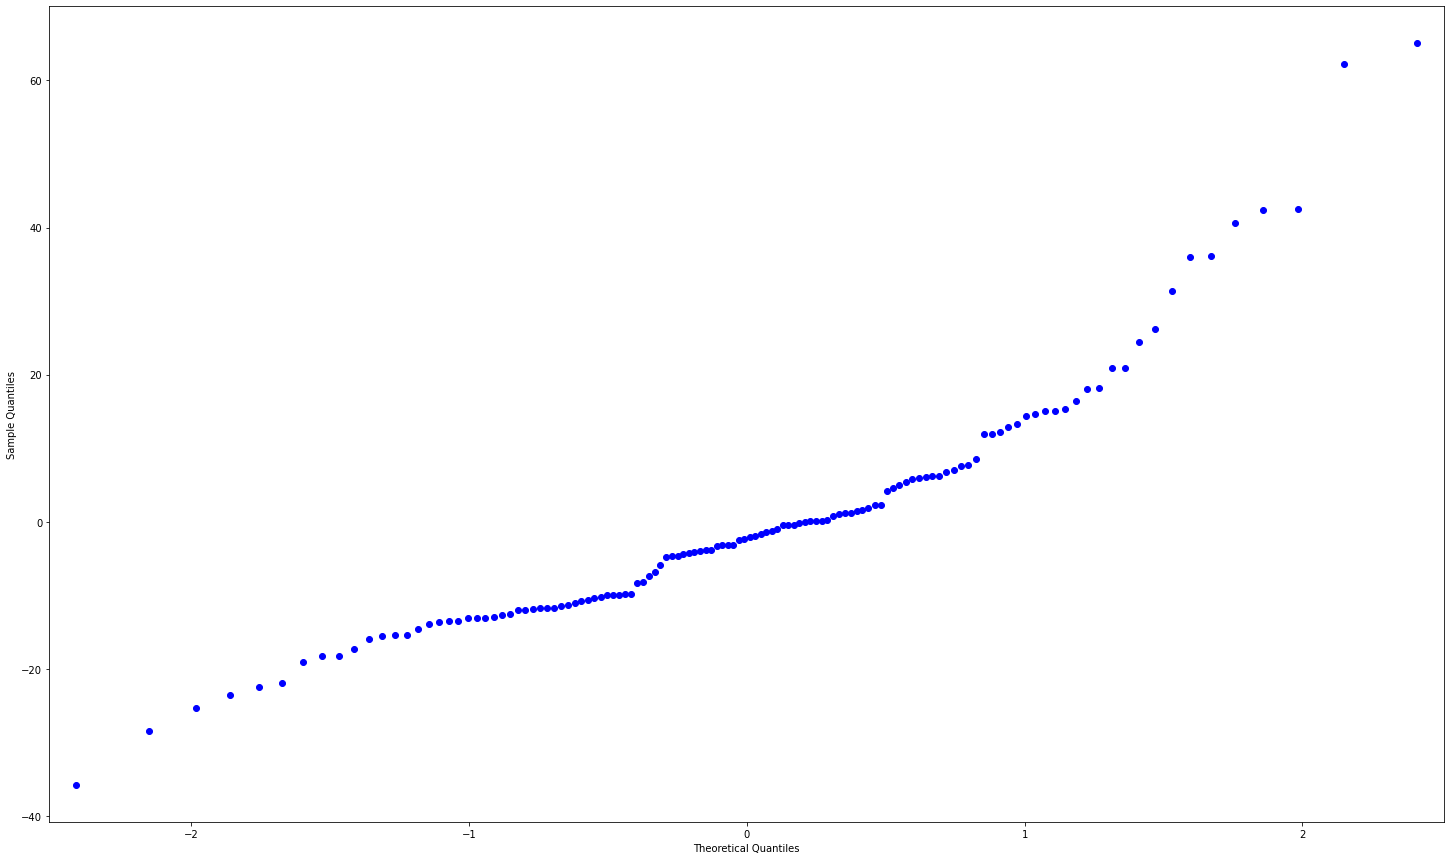

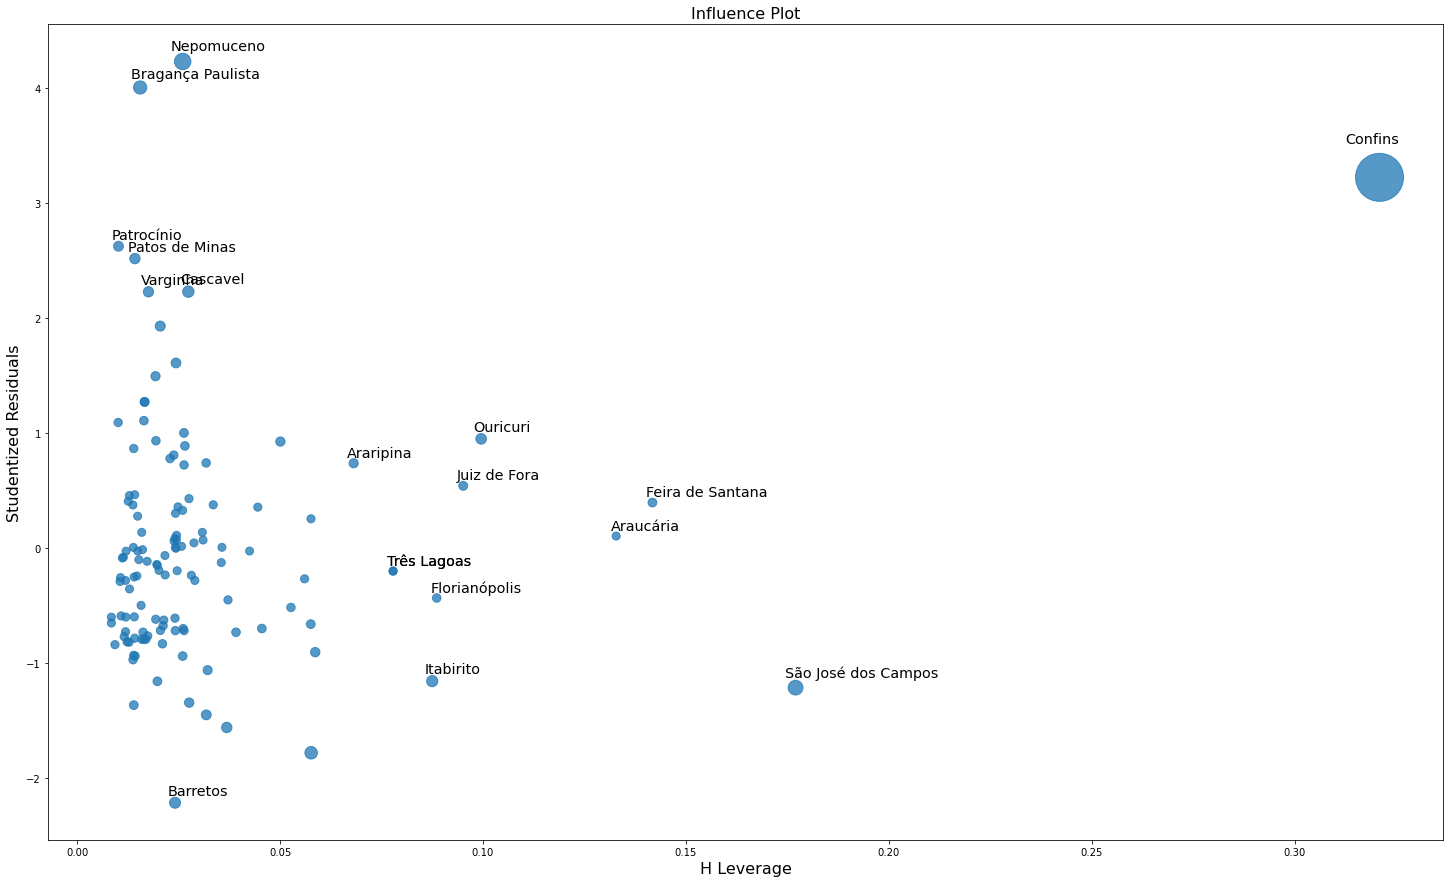

In [282]:
print(sm.qqplot(res.resid))
print(sm.graphics.influence_plot(res))

In [283]:
#A coleta para a cidade de Confins, claramente não funcionou
deposito.loc['Confins',:]

Unnamed: 0                                     241
Unnamed: 0.1                                   NaN
Negócio                     Depósito de construção
Contagem                                      88.0
Estado                                          MG
População                                     6800
IDH                                          0.747
pibPerCapita                             163730.37
Frota_Total                                   5457
Frota_Automóveis                              2882
Frota_Motos                                    791
Total_por_habitantes                        0.8025
Automoveis_por_habitante                  0.423824
Motos_por_habitante                       0.116324
Carro_por_moto                            3.643489
Name: Confins, dtype: object

In [284]:
print(len(deposito))
#Removendo o dado de Confins
deposito.drop(index = 'Confins', inplace=True)
print(len(deposito))

126
125


                            OLS Regression Results                            
Dep. Variable:               Contagem   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     78.58
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           2.82e-28
Time:                        13:49:22   Log-Likelihood:                -522.01
No. Observations:                 125   AIC:                             1052.
Df Residuals:                     121   BIC:                             1063.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -75.0678     24.206     -3.101   

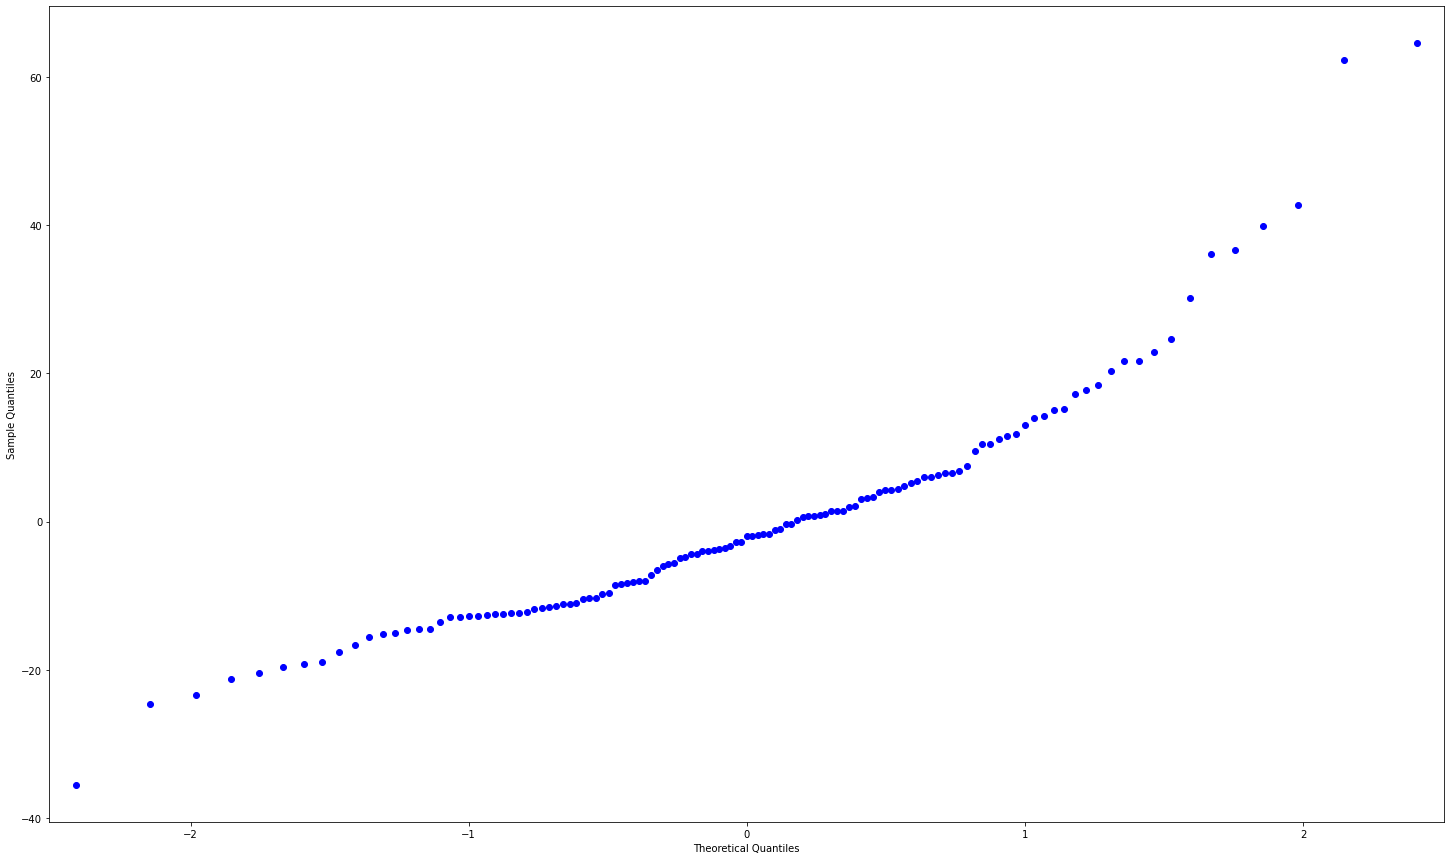

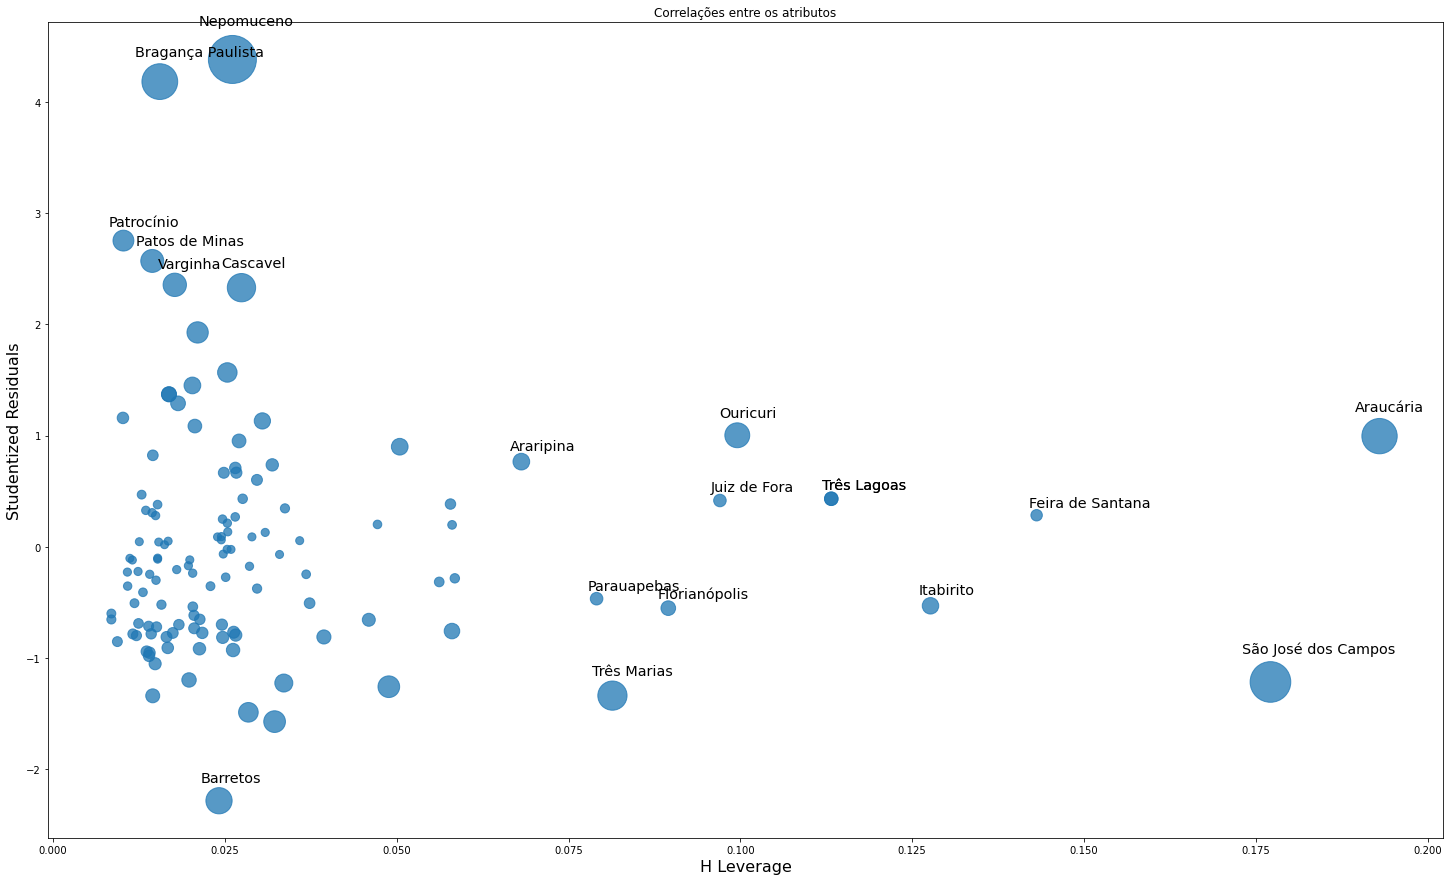

In [285]:
#Plotando novamente os resultados sem a coleta incoerente
reg = smf.ols('Contagem ~ População + pibPerCapita + IDH' , data = deposito)
res = reg.fit()
print(res.summary())
print(sm.qqplot(res.resid))
sm.graphics.influence_plot(res)
plt.title("Correlações entre os atributos")
plt.rc("figure", figsize=(25,15))
plt.show()

In [286]:
#Dessa vez os dados mais suspeitos são os de Bragança Paulista, Nepomuceno e Araucária
deposito.loc[['Bragança Paulista','Nepomuceno','Araucária']]

,Unnamed: 0,Unnamed: 0.1,Negócio,Contagem,Estado,População,IDH,pibPerCapita,Frota_Total,Frota_Automóveis,Frota_Motos,Total_por_habitantes,Automoveis_por_habitante,Motos_por_habitante,Carro_por_moto
Cidade,,,,,,,,,,,,,,,
Bragança Paulista,198,NaN,Depósito de construção,115.2,SP,170533,0.776,37813.45,134740,76388,29258,0.790111,0.447937,0.171568,2.610841
Nepomuceno,250,NaN,Depósito de construção,81.6,MG,26826,0.667,17122.86,14932,8909,2843,0.556624,0.332103,0.105979,3.133662
Araucária,193,NaN,Depósito de construção,59.2,PR,146214,0.740,116046.97,93551,58715,11621,0.639822,0.401569,0.079479,5.052491


In [287]:
#Os dados para a cidade de Nepomuceno estão claramente errados. 
#Observando "ao vivo" a extração feita nas cidades de Bragança Paulista e Araucária, o que se notou é que foram coletados,
#de forma indevida, dados de cidades vizinhas.

# Os dados dessas três cidades serão removidos
deposito.drop(index = ['Bragança Paulista','Nepomuceno','Araucária'], inplace = True)

                            OLS Regression Results                            
Dep. Variable:               Contagem   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     108.5
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           8.83e-34
Time:                        13:49:24   Log-Likelihood:                -491.53
No. Observations:                 122   AIC:                             991.1
Df Residuals:                     118   BIC:                             1002.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -79.6978     21.269     -3.747   

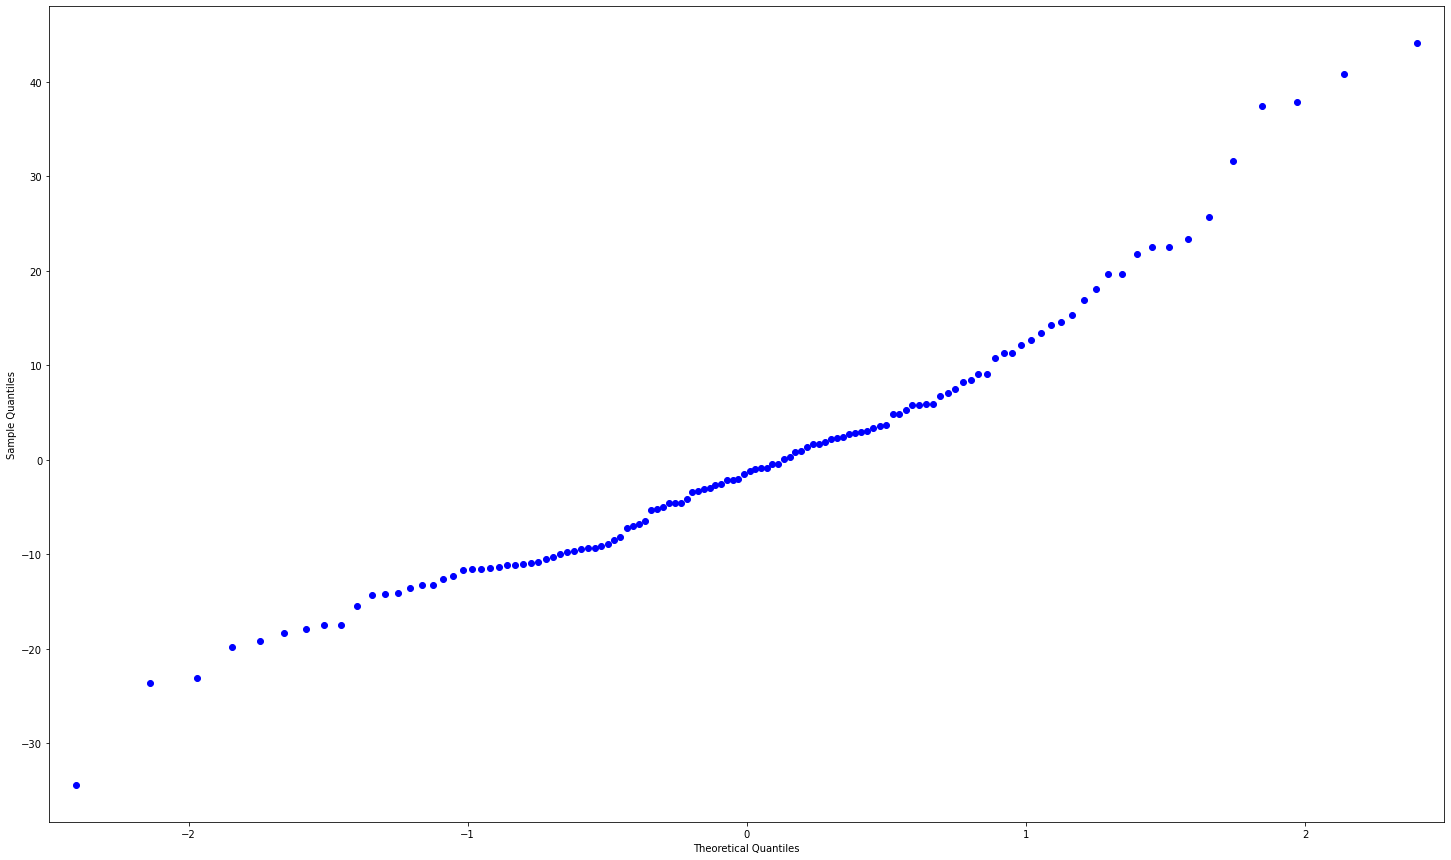

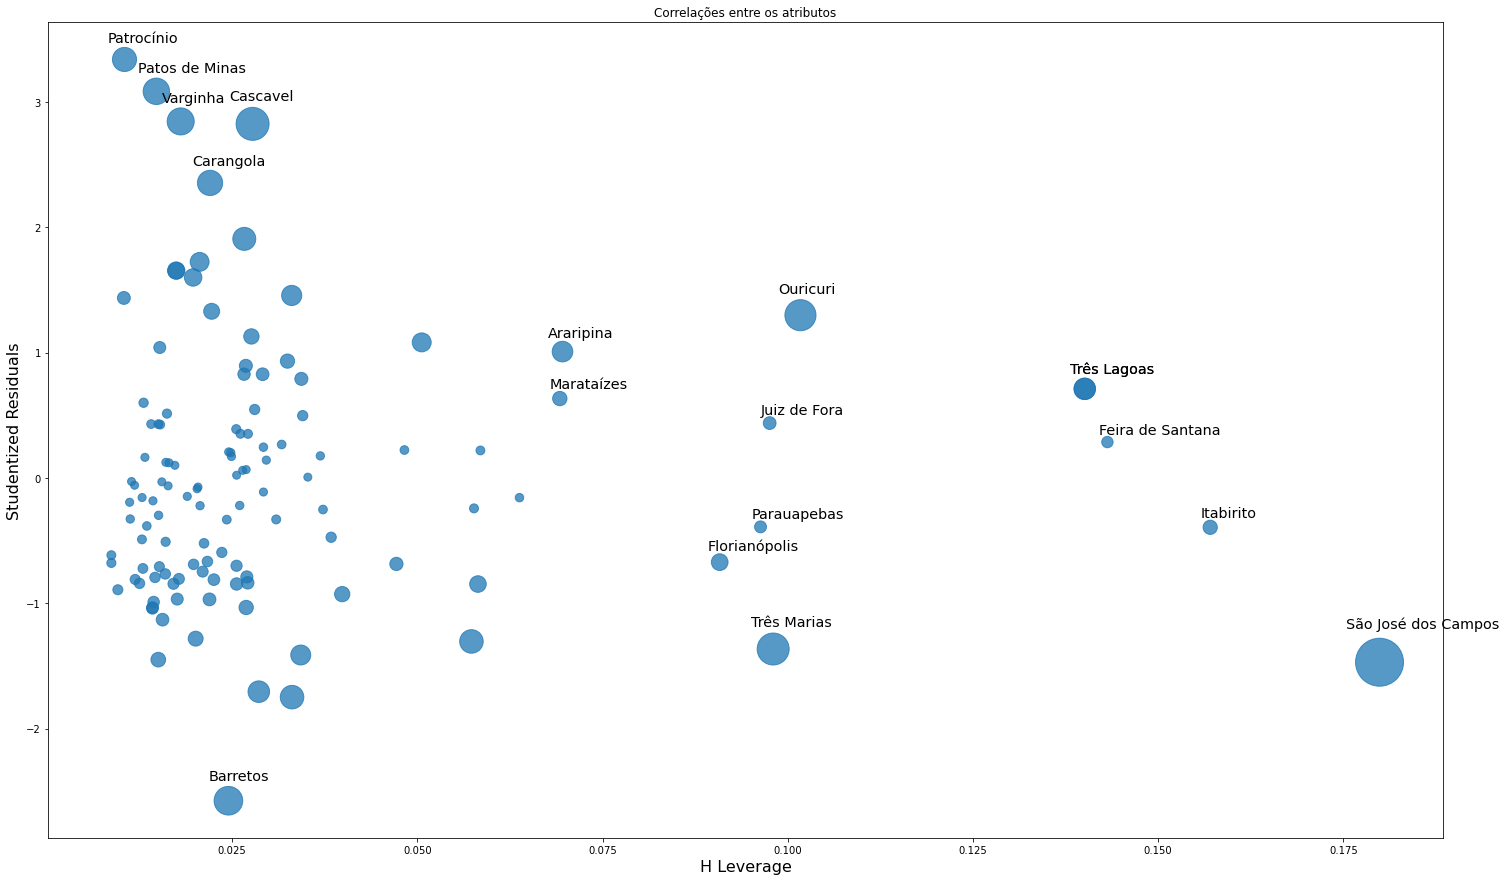

In [288]:
#Fazendo a regressão novamente
reg = smf.ols('Contagem ~ População + pibPerCapita + IDH' , data = deposito)
res = reg.fit()
print(res.summary())
print(sm.qqplot(res.resid))
sm.graphics.influence_plot(res)
plt.title("Correlações entre os atributos")
plt.rc("figure", figsize=(25,15))
plt.show()

In [289]:
#Dessa vez se olhou as cidades localizadas no canto superior e inferior esquerdo, e se concluiu (acompanhando novamente a 
#extração "ao vivo") que as cidades de Patrocínio, Patos de Minas, Varginha,Carangola e Pedro Leopoldo e Palmas
#devem ser removidas do estudo.
deposito.drop(index = ['Patrocínio','Patos de Minas','Carangola','Varginha','Barretos',
                       'Cascavel','Pedro Leopoldo','Palmas'], inplace = True)

                            OLS Regression Results                            
Dep. Variable:               Contagem   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     184.8
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           8.44e-43
Time:                        13:49:24   Log-Likelihood:                -429.28
No. Observations:                 114   AIC:                             866.6
Df Residuals:                     110   BIC:                             877.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -61.9349     16.874     -3.670   

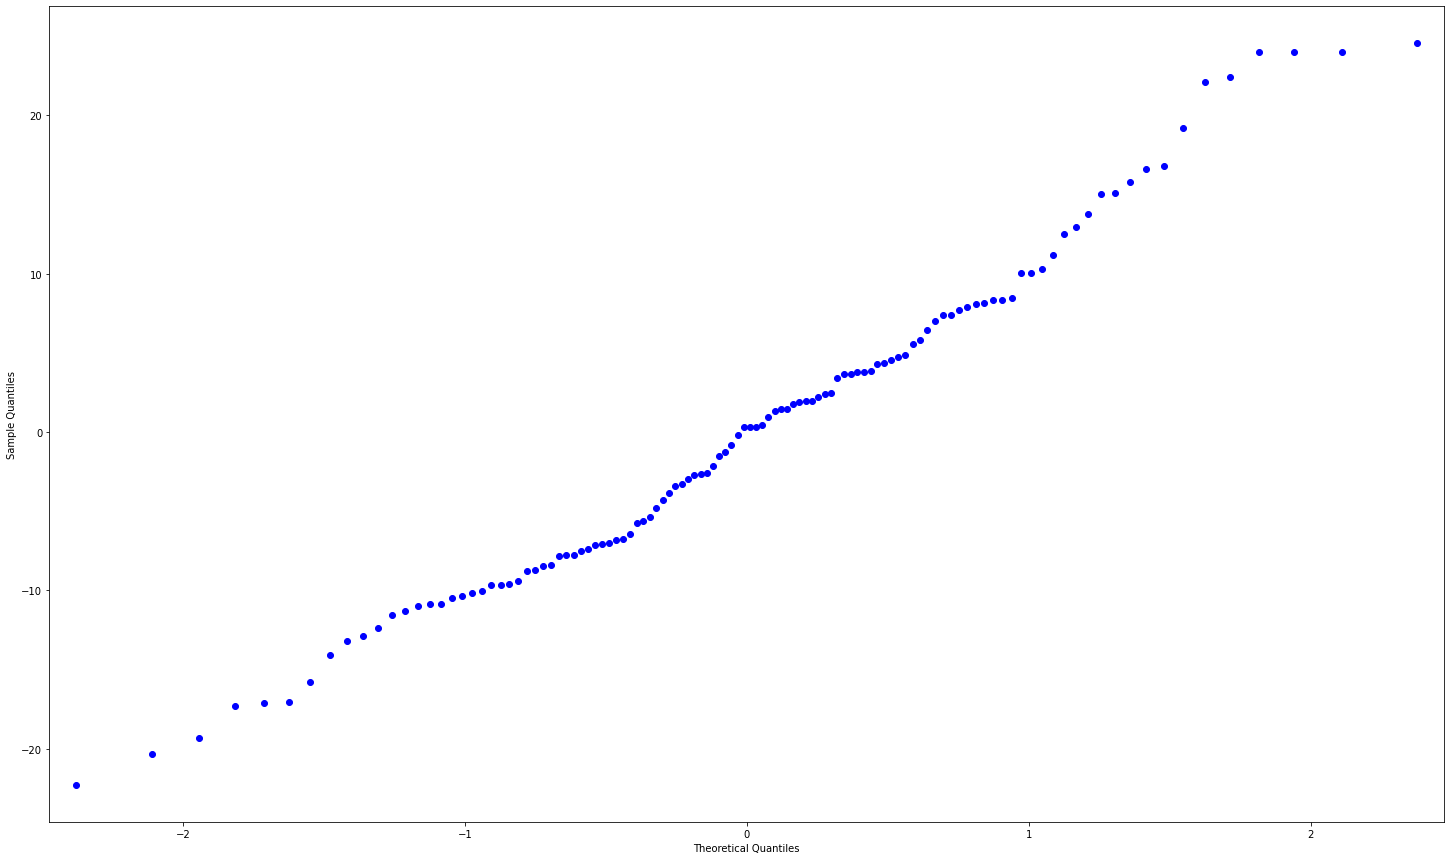

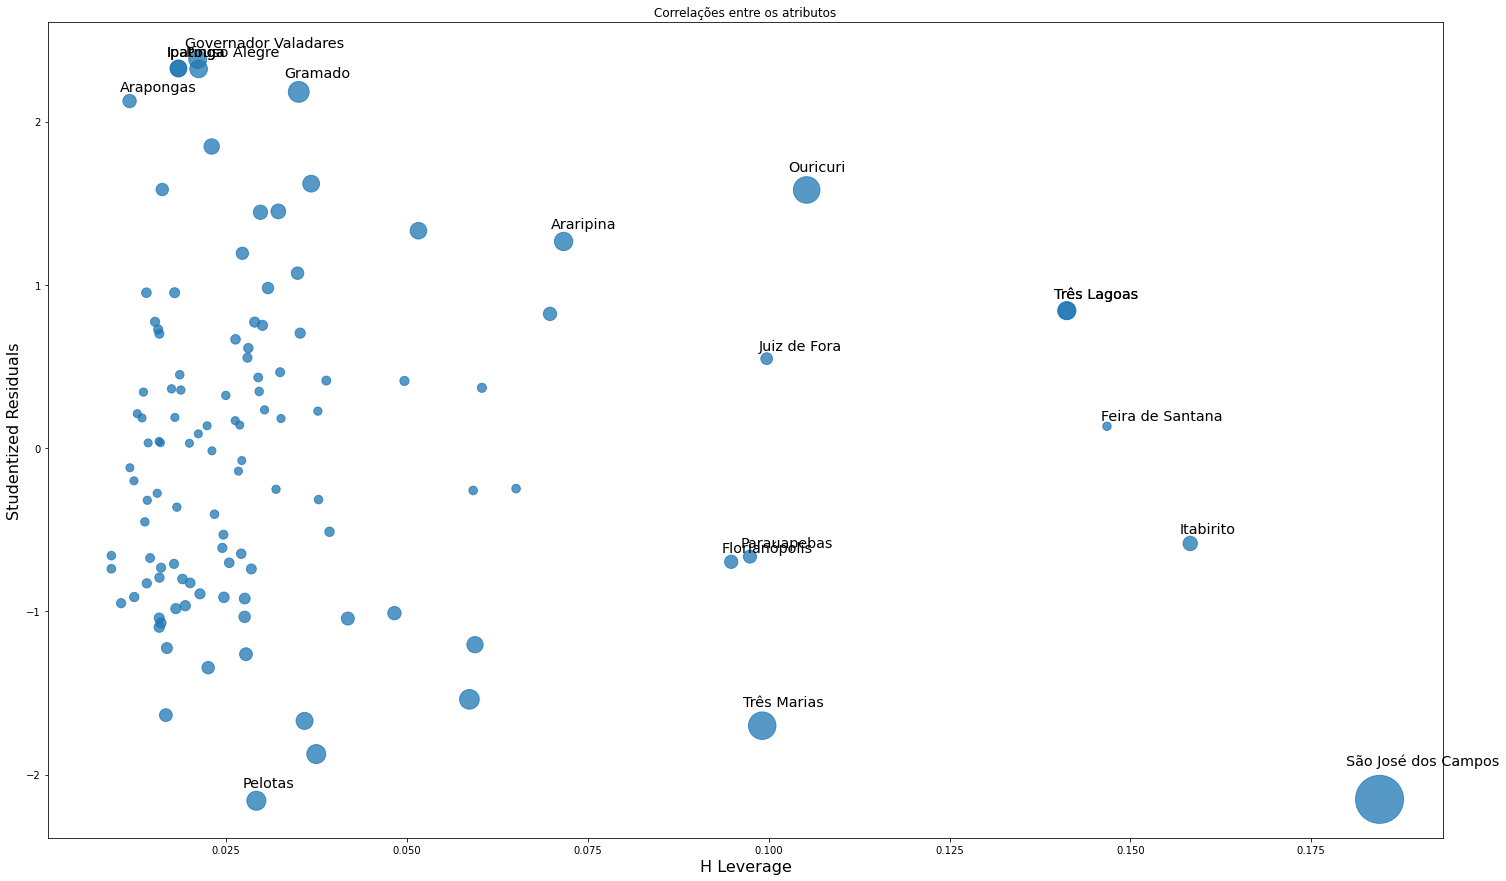

In [290]:
#Fazendo a regressão novamente
reg = smf.ols('Contagem ~ População + pibPerCapita + IDH' , data = deposito)
res = reg.fit()
print(res.summary())
print(sm.qqplot(res.resid))
sm.graphics.influence_plot(res)
plt.title("Correlações entre os atributos")
plt.rc("figure", figsize=(25,15))
plt.show()

**Última iteração da regressão e armazenamento dos seus parâmetros**

                            OLS Regression Results                            
Dep. Variable:               Contagem   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     278.8
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           5.20e-44
Time:                        13:49:25   Log-Likelihood:                -429.44
No. Observations:                 114   AIC:                             864.9
Df Residuals:                     111   BIC:                             873.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -65.2908     15.699     -4.159      0.0

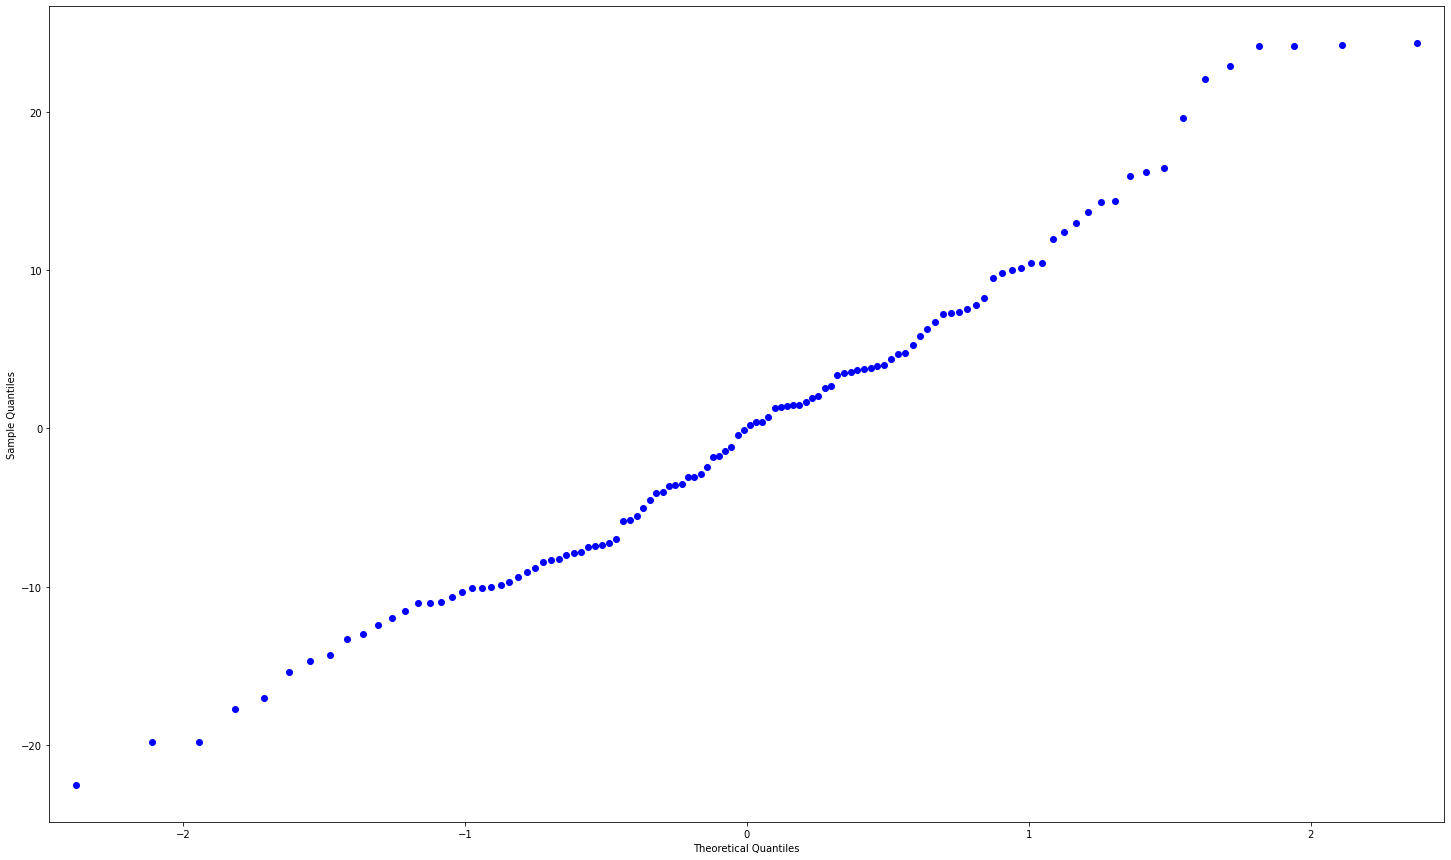

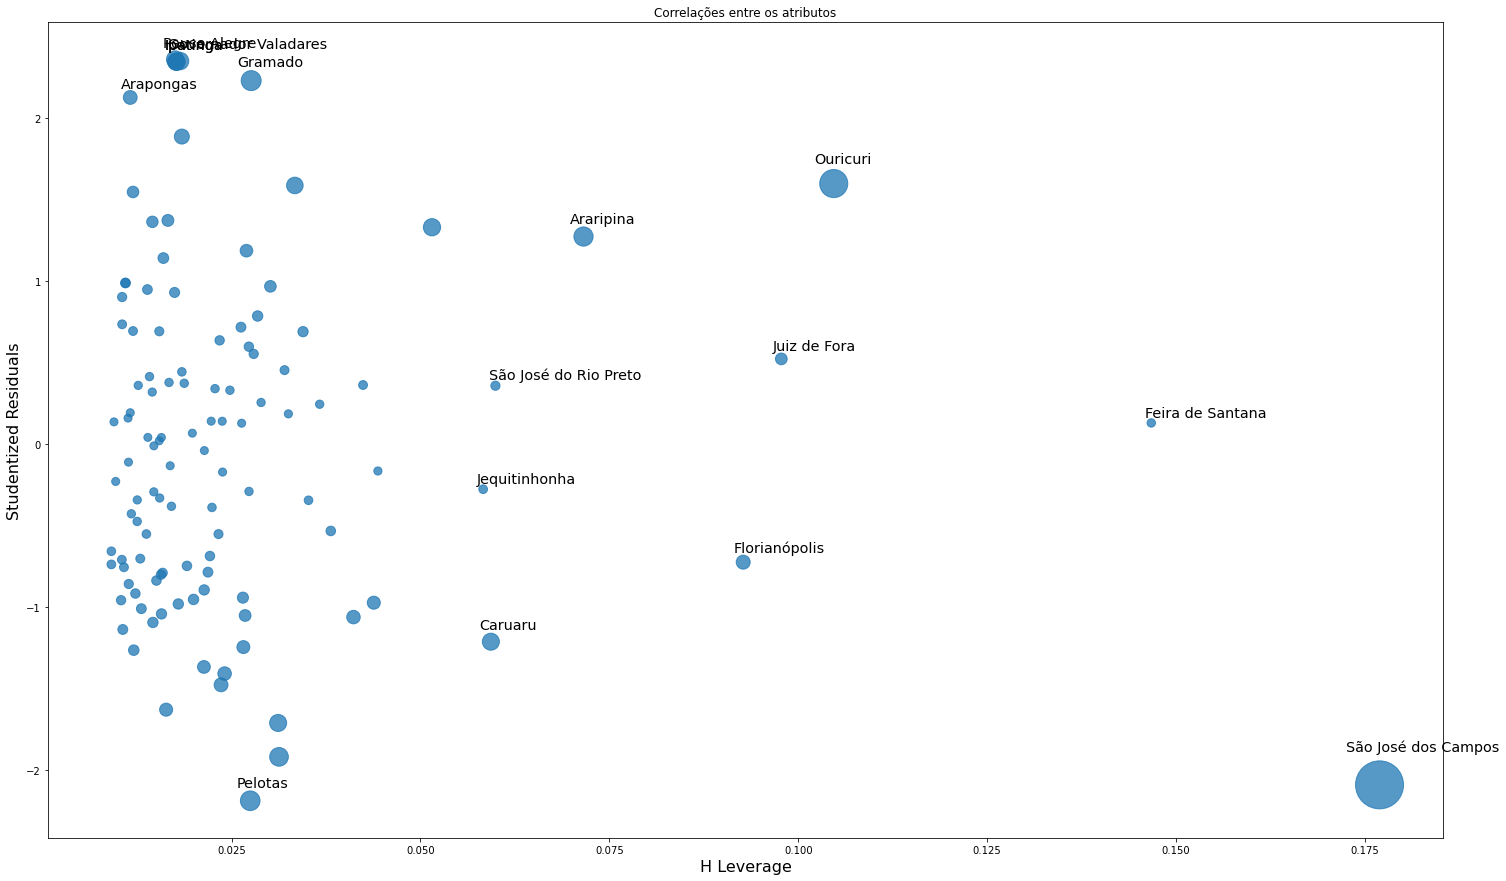

In [291]:
#Removendo a variável pibPerCapita e substituindo
regDepositos = smf.ols('Contagem ~ População + IDH ' , data = deposito)
resDepositos = regDepositos.fit()
print(resDepositos.summary())
print(sm.qqplot(resDepositos.resid))
sm.graphics.influence_plot(resDepositos)
plt.title("Correlações entre os atributos")
plt.rc("figure", figsize=(25,15))
plt.show()

(3) Estimando quantidade de **petshops**

Primeira iteração da regressão múltipla

In [292]:
petshop

,Unnamed: 0,Unnamed: 0.1,Negócio,Contagem,Estado,População,IDH,pibPerCapita,Frota_Total,Frota_Automóveis,Frota_Motos,Total_por_habitantes,Automoveis_por_habitante,Motos_por_habitante,Carro_por_moto
Cidade,,,,,,,,,,,,,,,
Lucas do Rio Verde,260,NaN,Pet Shop,13.00,MT,67620,0.768,72058.74,55565,17404,12593,0.821724,0.257379,0.186232,1.382038
Florianópolis,261,NaN,Pet Shop,139.20,SC,508826,0.847,42719.16,370302,231978,51638,0.727758,0.455908,0.101485,4.492389
Chapecó,262,NaN,Pet Shop,56.10,SC,224013,0.790,44321.07,191496,105431,28924,0.854843,0.470647,0.129118,3.645104
Tubarão,263,NaN,Pet Shop,40.80,SC,106422,0.796,35655.22,98993,49876,18205,0.930193,0.468662,0.171064,2.739687
Ponta Grossa,264,NaN,Pet Shop,104.80,PR,355336,0.763,43253.34,226527,136556,27759,0.637501,0.384301,0.078120,4.919341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tangará da Serra,380,NaN,Pet Shop,14.40,MT,105711,0.729,31823.37,74547,25109,20501,0.705196,0.237525,0.193934,1.224770
Santarém,381,NaN,Pet Shop,39.95,PA,306480,0.691,16053.85,113088,37750,46916,0.368990,0.123173,0.153080,0.804630
Parauapebas,382,NaN,Pet Shop,20.70,PA,213576,0.715,78841.15,107782,31588,36750,0.504654,0.147901,0.172070,0.859537


                            OLS Regression Results                            
Dep. Variable:               Contagem   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     214.1
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           1.57e-45
Time:                        13:49:26   Log-Likelihood:                -451.05
No. Observations:                 113   AIC:                             910.1
Df Residuals:                     109   BIC:                             921.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -151.5122     21.043     -7.200   

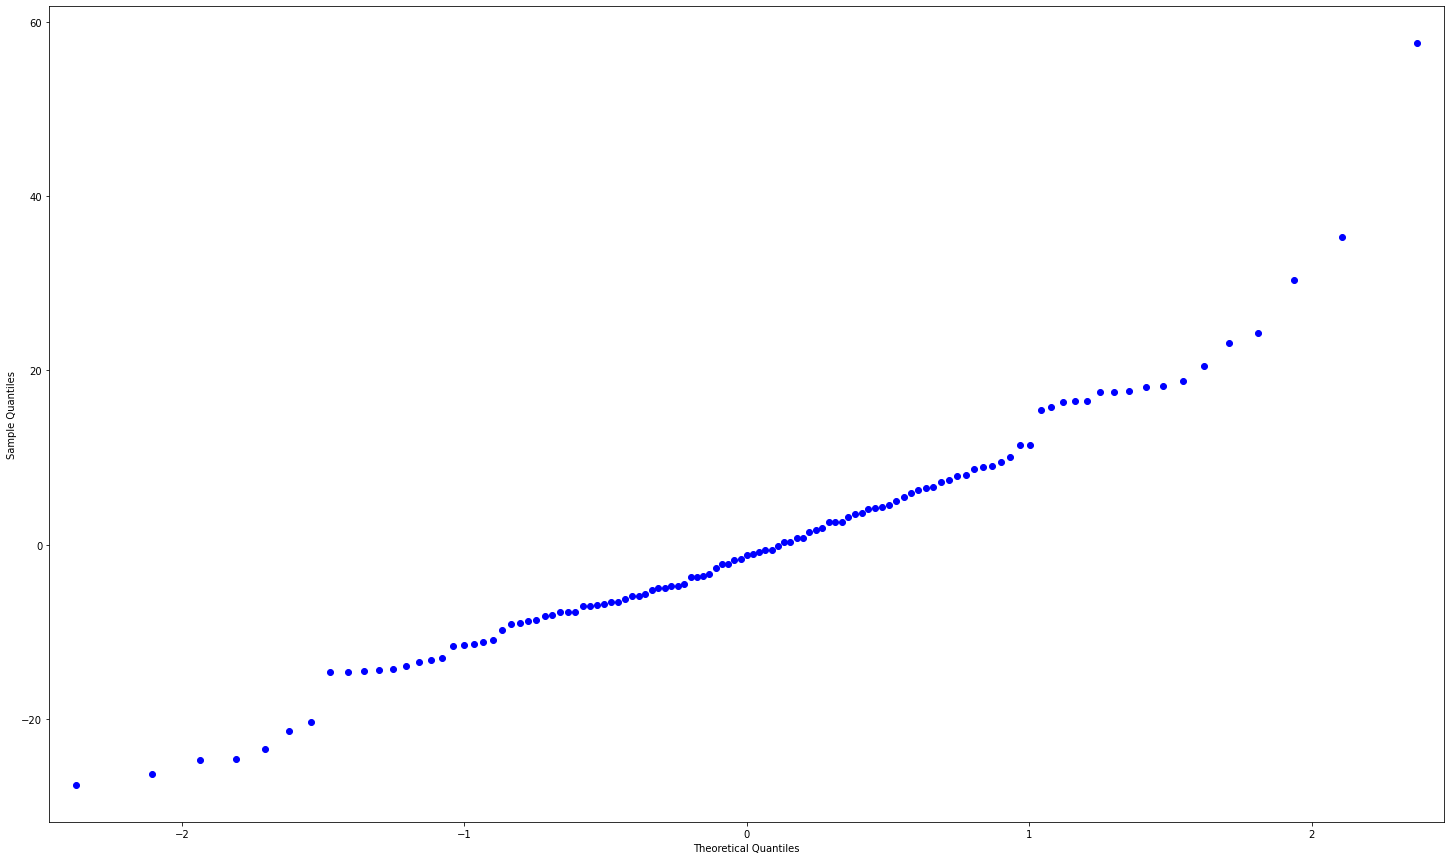

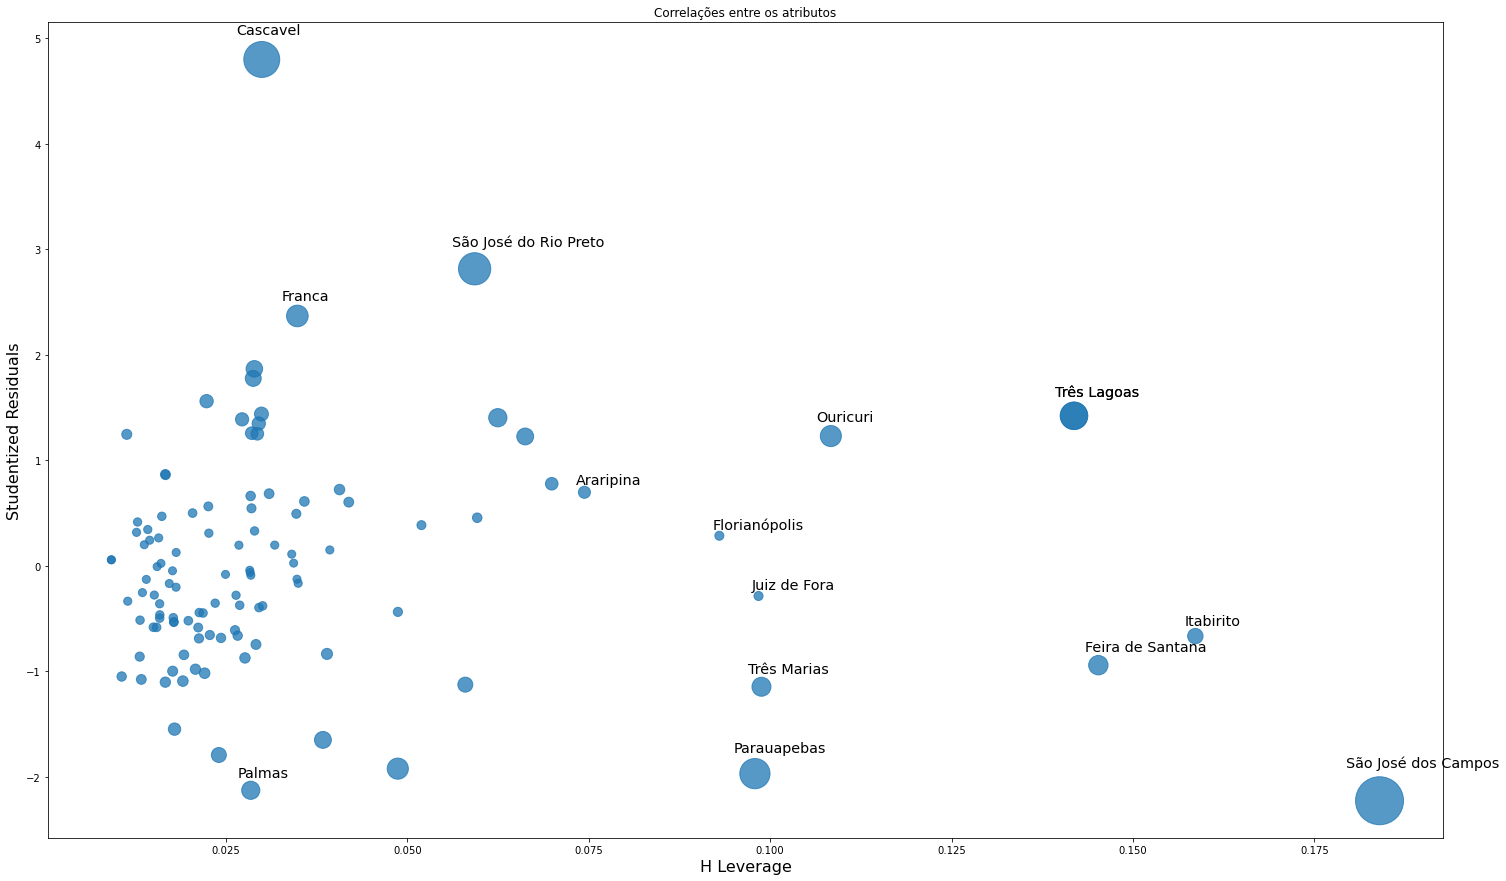

In [293]:
#Serão removidas logo de início as cidades para as quais não foi possível efetuar uma boa coleta anteriormente
suspeitas = ['Patrocínio','Patos de Minas','Carangola','Varginha',
            'Confins','Pedro Leopoldo','Bragança Paulista','Nepomuceno','Araucária']
petshop.drop(index = suspeitas, inplace = True)

#Efetuando a regressão
reg = smf.ols('Contagem ~ População + IDH + pibPerCapita' , data = petshop)
res = reg.fit()
print(res.summary())
print(sm.qqplot(res.resid))
sm.graphics.influence_plot(res)
plt.title("Correlações entre os atributos")
plt.rc("figure", figsize=(25,15))
plt.show()

**Última iteração da regressão e armazenamento dos seus parâmetros**

                            OLS Regression Results                            
Dep. Variable:               Contagem   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     392.2
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           1.62e-50
Time:                        13:49:27   Log-Likelihood:                -436.79
No. Observations:                 112   AIC:                             879.6
Df Residuals:                     109   BIC:                             887.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -137.9139     18.073     -7.631      0.0

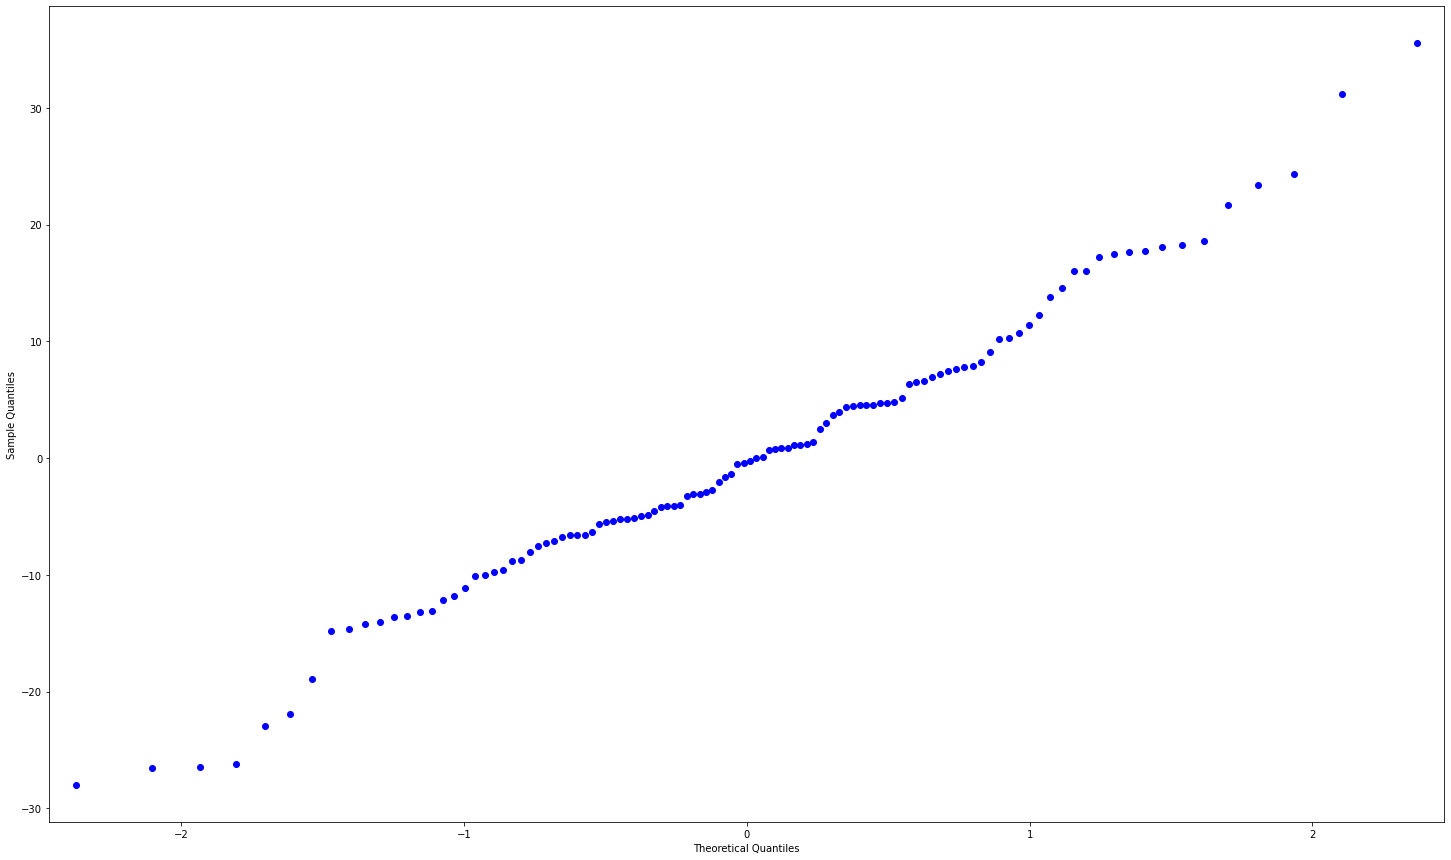

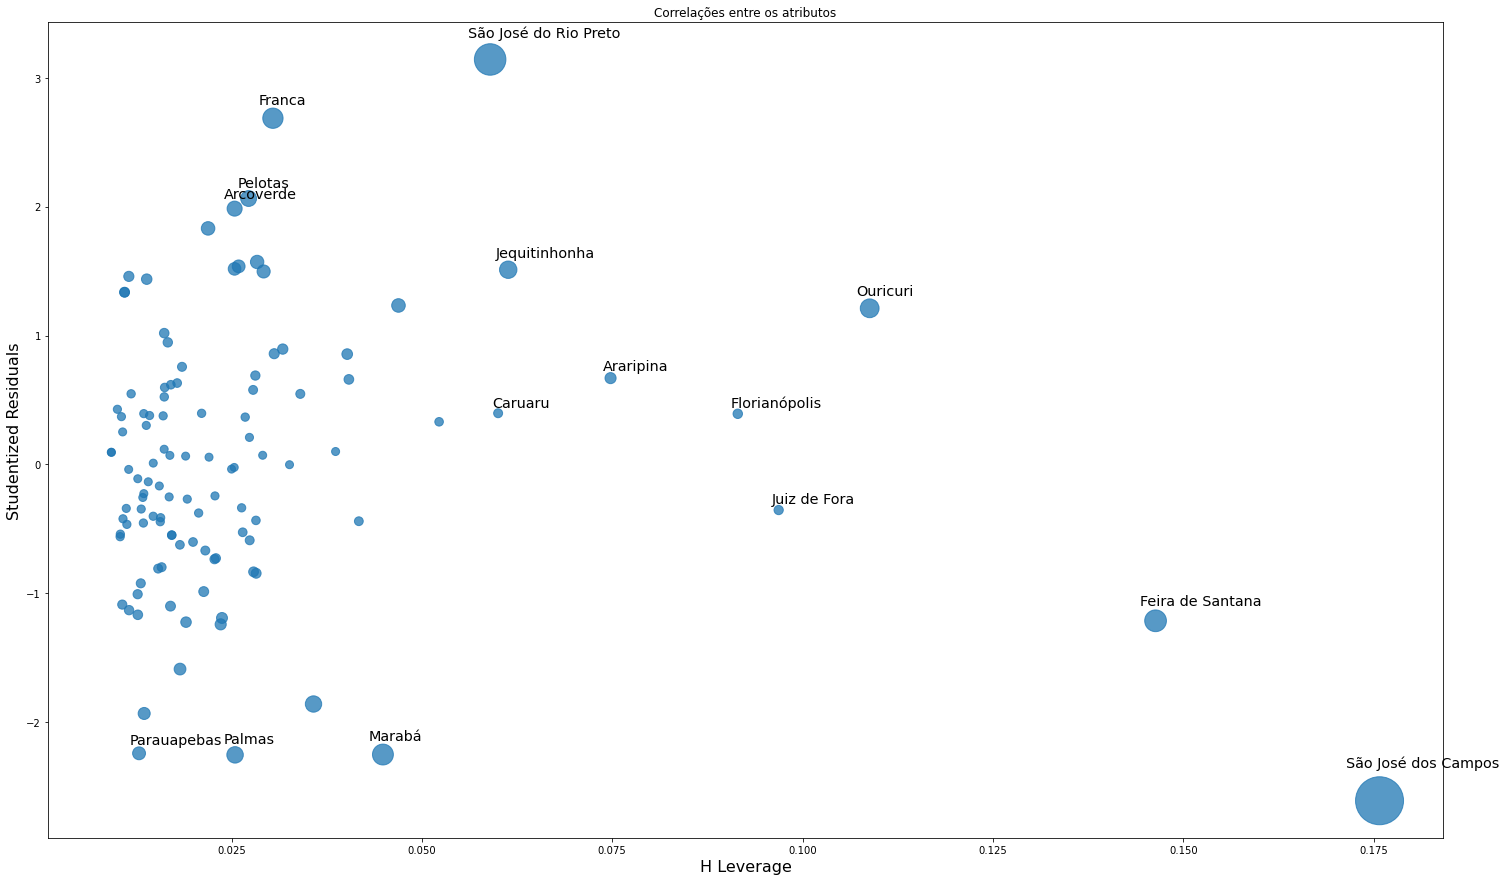

In [294]:
#Achou-se melhor dessa vez também remover a cidade de Cascável, e substituir a variável pibPerCapita por
#Carro_por_moto

petshop.drop(index = 'Cascavel', inplace = True)

#Efetuando a regressão
regPet = smf.ols('Contagem ~ População + IDH' , data = petshop)
resPet = regPet.fit()
print(resPet.summary())
print(sm.qqplot(resPet.resid))
sm.graphics.influence_plot(resPet)
plt.title("Correlações entre os atributos")
plt.rc("figure", figsize=(25,15))
plt.show()

**Checando a colinearidade entre as variáveis**

In [295]:
correlacoes = postos[['pibPerCapita','População','Frota_Total','IDH','Automoveis_por_habitante',
                       'Frota_Automóveis', 'Frota_Motos','Total_por_habitantes','Motos_por_habitante', 'Carro_por_moto'
                       ]].corr()

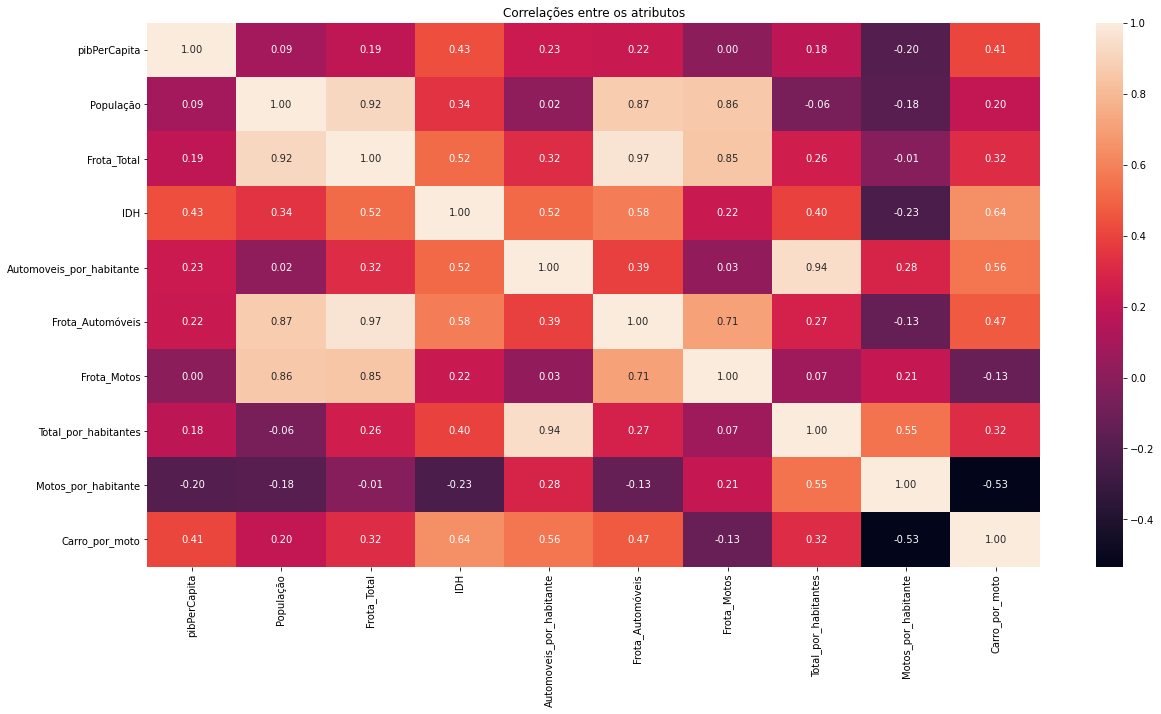

In [296]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(correlacoes,annot = True, fmt = ".2f")
plt.title("Correlações entre os atributos")
plt.show()

In [297]:
#Dados de validação
postosVal = validacao[validacao['Negócio']=="Posto de gasolina"].set_index('Cidade')
depositosVal= validacao[validacao['Negócio']=="Depósito de construção"].set_index('Cidade')
petshopsVal = validacao[validacao['Negócio']=="Pet Shop"].set_index('Cidade')

#### Plotando os resultados

Postos de gasolina

In [298]:
import numpy as np

#Relembrando... para postos de gasolina as variáveis explicativas finais foram:
#frota de automóveis, frota de motos, e razão entre frota de carros e motos.
exPostos = postos[['Frota_Automóveis', 'Frota_Motos', 'Carro_por_moto']]

#Adicionando o número "1" em todas linhas, para ser o multiplicador do parâmetro "intercept"
exPostos = sm.add_constant(exPostos)

#De fato efetuando a previsão 
prevPostos = regPostos.predict(resPostos.params, exPostos)
#Criando um DataFrame das previsões efetuadas
previsoes = pd.DataFrame(data = prevPostos, columns = ['Previsão'],index = exPostos.index)

#Criando um único DataFrame com as previsões, observações reais, e variáveis explicativas
postosFinal = pd.concat([exPostos, previsoes, postos['Contagem']], axis = 1)
postosFinal.head()

,const,Frota_Automóveis,Frota_Motos,Carro_por_moto,Previsão,Contagem
Cidade,,,,,,
Imperatriz,1.0,49909,58675,0.850601,82.350752,96.00
Três Lagoas,1.0,41118,22064,1.863579,42.339894,38.25
Sinop,1.0,44496,34153,1.302843,54.755699,63.20
Caldas Novas,1.0,26551,19015,1.396319,33.298559,40.80
Divinópolis,1.0,82592,30887,2.674005,66.141007,60.00


In [299]:
exPostosVal = postosVal[['Frota_Automóveis', 'Frota_Motos', 'Carro_por_moto']]
exPostosVal = sm.add_constant(exPostosVal)
postosValPrev = regPostos.predict(resPostos.params, exPostosVal)
previsoesVal = pd.DataFrame(data = postosValPrev, columns = ['Previsão'],index = postosVal.index)
#Criando um único DataFrame com as previsões, observações reais, e variáveis explicativas
postosPrevFinal = pd.concat([exPostosVal, previsoesVal, postosVal['Contagem']], axis = 1)


In [300]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x = postosFinal['Previsão'],
                         y = postosFinal['Contagem'],
                         mode='markers',
                         hoverinfo = ['text','x','y'],
                         hovertext = postosFinal.index,
                         showlegend = False))

fig.add_trace(go.Scatter(x = np.arange(0,180),
                         y = np.arange(0,180),
                         fill ='tozeroy',
                         mode = 'lines',
                         line_color = 'limegreen',
                         name = 'Potencial para investimento'))

fig.add_trace(go.Scatter(x = postosPrevFinal['Previsão'],
                         y = postosPrevFinal['Contagem'],
                         mode='markers',
                         marker = dict(symbol =  'diamond-x-open',
                                       color = 'red'),
                         hoverinfo = ['text','x','y'],
                         hovertext = postosPrevFinal.index,
                         showlegend = True,
                         name = "Dados de Validação"))

fig.update_layout(title='Postos de Gasolina - Quantos "cabem" na cidade vs. quantos já existem',
                   xaxis_title='Estimativa de quantos negócios poderiam existir',
                   yaxis_title='Número real de negócios')
fig.show()

Depósitos de construção

In [301]:
#Relembrando... para depósitos de construção, as variáveis explicativas finais foram:
#População, IDH e razão entre frota de carros e motos.
exDepositos = deposito[['População', 'IDH']]

#Adicionando o número "1" em todas linhas, para ser o multiplicador do parâmetro "intercept"
exDepositos = sm.add_constant(exDepositos)

#De fato efetuando a previsão 
prevDepositos = regDepositos.predict(resDepositos.params, exDepositos)
#Criando um DataFrame das previsões efetuadas
previsoes = pd.DataFrame(data = prevDepositos, columns = ['Previsão'],index = exDepositos.index)

#Criando um único DataFrame com as previsões, observações reais, e variáveis explicativas
depositosFinal = pd.concat([exDepositos, previsoes, deposito['Contagem']], axis = 1)
depositosFinal.head()

,const,População,IDH,Previsão,Contagem
Cidade,,,,,
Imperatriz,1.0,259337,0.731,58.343748,55.25
Três Lagoas,1.0,123281,0.744,38.010835,48.45
Sinop,1.0,146005,0.754,42.773722,38.25
Caldas Novas,1.0,93196,0.733,31.956589,34.00
Divinópolis,1.0,240408,0.764,59.017850,62.40


In [302]:
exDepositosVal = depositosVal[['População', 'IDH']]
exDepositosVal = sm.add_constant(exDepositosVal)
depositosValPrev = regDepositos.predict(resDepositos.params, exDepositosVal)
previsoesVal = pd.DataFrame(data = depositosValPrev, columns = ['Previsão'],index = depositosVal.index)
#Criando um único DataFrame com as previsões, observações reais, e variáveis explicativas
depositosPrevFinal = pd.concat([exDepositosVal, previsoesVal, depositosVal['Contagem']], axis = 1)

In [303]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = depositosFinal['Previsão'],
                         y = depositosFinal['Contagem'],
                         mode='markers',
                         hoverinfo = ['text','x','y'],
                         hovertext = depositosFinal.index,
                         showlegend = False))

fig.add_trace(go.Scatter(x = np.arange(0,150),
                         y = np.arange(0,150),
                         fill ='tozeroy',
                         mode = 'lines',
                         line_color = 'limegreen',
                         name = 'Potencial para investimento'))

fig.add_trace(go.Scatter(x = depositosPrevFinal['Previsão'],
                         y = depositosPrevFinal['Contagem'],
                         mode='markers',
                         marker = dict(symbol =  'diamond-x-open',
                                       color = 'red'),
                         hoverinfo = ['text','x','y'],
                         hovertext = depositosPrevFinal.index,
                         showlegend = True,
                         name = "Dados de Validação"))

fig.update_layout(title='Depósitos de construção - Quantos "cabem" na cidade vs. quantos já estão presentes',
                   xaxis_title='Estimativa de quantos negócios poderiam existir',
                   yaxis_title='Número real de negócios')
fig.show()

Petshops

In [304]:
#Relembrando... para Petshops, as variáveis explicativas finais foram:
#População e IDH
exPetshops = petshop[['População', 'IDH']]

#Adicionando o número "1" em todas linhas, para ser o multiplicador do parâmetro "intercept"
exPetshops = sm.add_constant(exPetshops)

#De fato efetuando a previsão 
prevPetshops = regPet.predict(resPet.params, exPetshops)
#Criando um DataFrame das previsões efetuadas
previsoes = pd.DataFrame(data = prevPetshops, columns = ['Previsão'],index = exPetshops.index)

#Criando um único DataFrame com as previsões, observações reais, e variáveis explicativas
petshopsFinal = pd.concat([exPetshops, previsoes, petshop['Contagem']], axis = 1)
petshopsFinal.head()

,const,População,IDH,Previsão,Contagem
Cidade,,,,,
Lucas do Rio Verde,1.0,67620,0.768,27.242105,13.0
Florianópolis,1.0,508826,0.847,134.648187,139.2
Chapecó,1.0,224013,0.790,64.133169,56.1
Tubarão,1.0,106422,0.796,40.829256,40.8
Ponta Grossa,1.0,355336,0.763,86.165292,104.8


In [305]:
exPetshopsVal = petshopsVal[['População', 'IDH']]
exPetshopsVal = sm.add_constant(exPetshopsVal)
petshopsValPrev = regPet.predict(resPet.params, exPetshopsVal)
previsoesVal = pd.DataFrame(data = petshopsValPrev, columns = ['Previsão'],index = petshopsVal.index)
#Criando um único DataFrame com as previsões, observações reais, e variáveis explicativas
petshopsPrevFinal = pd.concat([exPetshopsVal, previsoesVal, petshopsVal['Contagem']], axis = 1)

In [306]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = petshopsFinal['Previsão'],
                         y = petshopsFinal['Contagem'],
                         mode='markers',
                         hoverinfo = ['text','x','y'],
                         hovertext = petshopsFinal.index,
                         showlegend = False))

fig.add_trace(go.Scatter(x = np.arange(0,200),
                         y = np.arange(0,200),
                         fill ='tozeroy',
                         mode = 'lines',
                         line_color = 'limegreen',
                         name = 'Potencial para investimento'))

fig.add_trace(go.Scatter(x = petshopsPrevFinal['Previsão'],
                         y = petshopsPrevFinal['Contagem'],
                         mode='markers',
                         marker = dict(symbol =  'diamond-x-open',
                                       color = 'red'),
                         hoverinfo = ['text','x','y'],
                         hovertext = petshopsPrevFinal.index,
                         showlegend = True,
                         name = "Dados de Validação"))

fig.update_layout(title='Petshops - Quantos "cabem" na cidade vs. quantos já existem',
                   xaxis_title='Estimativa de quantos negócios poderiam existir',
                   yaxis_title='Número real de negócios')
fig.show()

Estimador da quantidade de postos de gasolina

In [307]:
resPostos.params

Intercept          -0.785741
Frota_Automóveis    0.000251
Frota_Motos         0.001144
Carro_por_moto      4.045465
dtype: float64

In [308]:
K,A,B,C = resPostos.params
#Estimando a quantidade de postos em Araxá
frota_carros = 40855
frota_motos = 12263
carro_por_moto = frota_carros/frota_motos
n_postos = round(K+(frota_carros*A) + (frota_motos*B) + (carro_por_moto*C))
print(n_postos)

37


Estimador da quantidade de petshops

In [309]:
resPet.params

Intercept   -137.913868
População      0.000208
IDH          196.714169
dtype: float64

In [310]:
D,G,H = resPet.params
#Estimando a quantidade de petshops em Lagoa Santa
populacao = 66744
IDH = 0.777
n_petshops = round(D+(populacao*G) + (IDH*H))
print(n_petshops)

29
